## The Battle of Neighborhoods - Week 2
------

### Problem:

There is an enthusiastic entrepreneur who wants to create his own coffee shop in the city of Bogotá, Colombia. Colombia is a producer and consumer country of coffee, for this reason, this person wants to sell his products to people who love drink coffee and people who want to learn more about coffee, its preparation and the types of coffee that exist.

To start his business, this person is interested in opening your first store in an area where there is a high volume of people. His goal is to start a study of the city locations and their possible competitors in the market, that allows him to make a correct decision where he can open his first local.

### Data Sources:

#### City Localities
The city that I'm gonna use to this excercise is: ***Bogotá, Colombia***. The information about the locations of this city can be found in Wikipedia following the next link: <https://es.wikipedia.org/wiki/Anexo:Localidades_de_Bogot%C3%A1>

#### Foursquare
To ***Foursquare API***  will be used to gain the information about the competitors (nearby coffe shops, locations, distances, among others). For more information about Foursquare API visit <https://developer.foursquare.com/>

#### Libraries
- Pandas - Library for Data Analysis
- NumPy – Library to handle data in a vectorized manner
- JSON – Library to handle JSON files 
- Folium – Map rendering Library
- Matplotlib – Python Plotting Module 
- Geopy – To retrieve Location Data 
- Requests – Library to handle http requests
- bs4 – Scrapping tool

## Solution
------

#### Libraries

In [1]:
import folium
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

#### Methods

In [2]:
def scrape_site(url):
    headers = requests.utils.default_headers()
    headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })
    r = requests.get(url, headers)
    raw_html = r.content
    soup = BeautifulSoup(raw_html, 'html.parser')
    return soup

In [3]:
def get_table(soup, class_name):
    information = []
    table = soup.find("table", class_=class_name)
    table_rows = table.find_all('tr')
    for row in table_rows:
        info = row.text.split('\n')[1:-1]
        information.append(info)
    return information

In [4]:
def get_city_coodinates(neighborhood, city_name):
    url = 'http://nominatim.openstreetmap.org/search.php?q='+neighborhood+','+city_name+'&format=json&polygon=0'
    response = requests.get(url).json()[0]
    return response['lat'], response['lon']

In [5]:
def get_request_data(url):
    result = requests.get(url).json()
    return result

In [6]:
def foursquare_format_url(lat, lng, radius=900, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, limit)

In [7]:
def get_venues_info(neighborhood, lat, lng, fsq_response):   
    try:
        venues = fsq_response['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues) 
        filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng', 'venue.categories']
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['Neighborhood'] = neighborhood
        return nearby_venues
    except:
        pass

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Constraints

In [9]:
# Set Foursquare API config
CLIENT_ID = 'EXERCOQ420QGNLZ3JWZDOYYC0P2TSG3UW5VRSQMG40YJJAGL'
CLIENT_SECRET = 'DQJQABOZFJBWKBMWPTJFEUV5KNNKYFIBMOJBQRP5BSGTMHIQ'
CATEGORY_ID = '4bf58dd8d48988d16d941735' # Coffe ID Category
VERSION = '20190427' # Set version name like yearmonthday string

### Get Neighborhood information from Wikipedia
---

In [10]:
neighborhoods_url = "https://es.wikipedia.org/wiki/Anexo:Localidades_de_Bogot%C3%A1"
soup = scrape_site(neighborhoods_url)
bogota_df = get_table(soup, 'wikitable')
bogota_df = pd.DataFrame(bogota_df[1:], columns=bogota_df[0])
bogota_df.rename(columns={bogota_df.columns[2]: 'Neighborhood',
                            bogota_df.columns[4]: 'Postal Codes',
                            bogota_df.columns[6]: 'Surface',
                            bogota_df.columns[8]: 'Population',
                            bogota_df.columns[10]: 'Density'
                           }, 
                  inplace=True)
bogota_df = bogota_df.drop("", axis=1)
bogota_df

,Nº,Neighborhood,Postal Codes,Surface,Population,Density
0,01,Usaquén,110111-110151,65.31,501 999,7 686.4
1,02,Chapinero,110211-110231,38.15,139 701,3 661.88
2,03,Santa Fe,110311-110321,45.17,110 048,2 436.3
3,04,San Cristóbal,110411-110441,49.09,404 697,8 243.98
4,05,Usme,110511-110571,215.06,457 302,2 126.39
5,06,Tunjuelito,110611-110621,9.91,199 430,20 124.11
6,07,Bosa,110711-110741,23.93,673 077,28 126.91
7,08,Kennedy,110811-110881,38.59,1 088 443,28 205.31
8,09,Fontibón,110911-110931,33.28,394 648,11 858.41
9,10,Engativá,111011-111071,35.88,887 080,24 723.52


### Get Localities detail information
---

Add Latitude and Longitud for each Neighborhood

In [11]:
bogota_df['Latitude'] = 0
bogota_df['Longitude'] = 0
city_name = 'Bogota, Bogota Capital District'
for index, row in bogota_df.iterrows():    
    lat, lon = get_city_coodinates(row['Neighborhood'], city_name)
    bogota_df.loc[index, 'Latitude'] = lat
    bogota_df.loc[index, 'Longitude'] = lon
full_bogota_df = bogota_df
bogota_df

,Nº,Neighborhood,Postal Codes,Surface,Population,Density,Latitude,Longitude
0,01,Usaquén,110111-110151,65.31,501 999,7 686.4,4.6950465,-74.0314929
1,02,Chapinero,110211-110231,38.15,139 701,3 661.88,4.6471197,-74.0634584
2,03,Santa Fe,110311-110321,45.17,110 048,2 436.3,4.59376555,-74.0343138404862
3,04,San Cristóbal,110411-110441,49.09,404 697,8 243.98,4.5486579,-74.0474729042694
4,05,Usme,110511-110571,215.06,457 302,2 126.39,4.41113565,-74.1291076491203
5,06,Tunjuelito,110611-110621,9.91,199 430,20 124.11,4.5601479,-74.1289223837083
6,07,Bosa,110711-110741,23.93,673 077,28 126.91,4.62549175,-74.2002798089739
7,08,Kennedy,110811-110881,38.59,1 088 443,28 205.31,4.62968195,-74.1499354214614
8,09,Fontibón,110911-110931,33.28,394 648,11 858.41,4.67873705,-74.1469881692
9,10,Engativá,111011-111071,35.88,887 080,24 723.52,4.69662765,-74.1061199041956


### Get Localities Venues information
---

In [12]:
address = 'Bogotá, Colombia'
geolocator = Nominatim(user_agent="Bogota_Clustering")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Bogotá, Colombia are {}, {}'.format(latitude, longitude))

The geograpical coordinates of Bogotá, Colombia are 4.5980772, -74.0761028


Total of Coffee Shops by Neighborhood

In [13]:
bogota_df['Density'] = bogota_df['Density'].apply(lambda x: float(x.split()[0].replace(',', '')))

In [14]:
bogota_df.nlargest(5, 'Density')

,Nº,Neighborhood,Postal Codes,Surface,Population,Density,Latitude,Longitude
6,07,Bosa,110711-110741,23.93,673 077,28.0,4.62549175,-74.2002798089739
7,08,Kennedy,110811-110881,38.59,1 088 443,28.0,4.62968195,-74.1499354214614
17,18,Rafael Uribe Uribe,111811-111841,13.83,374 246,27.0,4.5734901,-74.1192075
9,10,Engativá,111011-111071,35.88,887 080,24.0,4.69662765,-74.1061199041956
14,15,Antonio Nariño,111511,4.88,109 176,22.0,4.5882529,-74.0974547


### Get Foursquare Data
------

In [15]:
full_venues_df = pd.DataFrame()
for index, row in bogota_df.iterrows():
    api_url = foursquare_format_url(row['Latitude'], row['Longitude'])
    api_response = get_request_data(api_url)
    full_venues_data = get_venues_info(row['Neighborhood'], row['Latitude'], row['Longitude'], api_response)
    if full_venues_data is not None:
        full_venues_df = full_venues_df.append(full_venues_data, ignore_index=True)

In [16]:
full_venues_df['venue.categories'] = full_venues_df.apply(get_category_type, axis=1)
full_venues_df.columns = [col.split(".")[-1] for col in full_venues_df.columns]
full_venues_df

,name,lat,lng,categories,Neighborhood
0,Parque Usaquén,4.695163,-74.030927,Park,Usaquén
1,La Puerta De Alcalá,4.694399,-74.029996,Spanish Restaurant,Usaquén
2,La Mar Cebichería,4.695834,-74.030330,Peruvian Restaurant,Usaquén
3,The Irish Pub,4.694826,-74.031661,Pub,Usaquén
4,Bicono,4.695179,-74.031988,Restaurant,Usaquén
5,Bogotá Beer Company,4.695506,-74.030360,Brewery,Usaquén
6,Osaki,4.695015,-74.031650,Asian Restaurant,Usaquén
7,Julia,4.696083,-74.030418,Pizza Place,Usaquén
8,Amarti,4.695503,-74.030637,Italian Restaurant,Usaquén
9,WOK Usaquén,4.694421,-74.031616,Asian Restaurant,Usaquén


### Working with Data
------

In [17]:
df_neighborhood_tmp = full_venues_df.groupby(['Neighborhood'])['categories'].apply(', '.join).reset_index()
count1 = full_venues_df.groupby(['Neighborhood']).count()
count1.reset_index(inplace=True)
df_neighborhood_tmp['count']=count1['name']
df_neighborhood_tmp.sort_values(by='count', ascending=False, inplace=True)
df_neighborhood_tmp.set_index('Neighborhood',inplace=True)
df_neighborhood_tmp

,categories,count
Neighborhood,,
Chapinero,"Vegetarian / Vegan Restaurant, Latin American ...",100
La Candelaria,"Art Museum, Theater, Cultural Center, Art Muse...",100
Usaquén,"Park, Spanish Restaurant, Peruvian Restaurant,...",100
Antonio Nariño,"Pie Shop, Salon / Barbershop, Gym, Sandwich Pl...",34
Barrios Unidos,"Latin American Restaurant, BBQ Joint, Fast Foo...",28
Teusaquillo,"French Restaurant, Hot Dog Joint, Coffee Shop,...",27
Los Mártires,"Latin American Restaurant, Farmers Market, Cof...",22
Kennedy,"Caribbean Restaurant, Burger Joint, Burger Joi...",18
Puente Aranda,"Latin American Restaurant, Seafood Restaurant,...",16


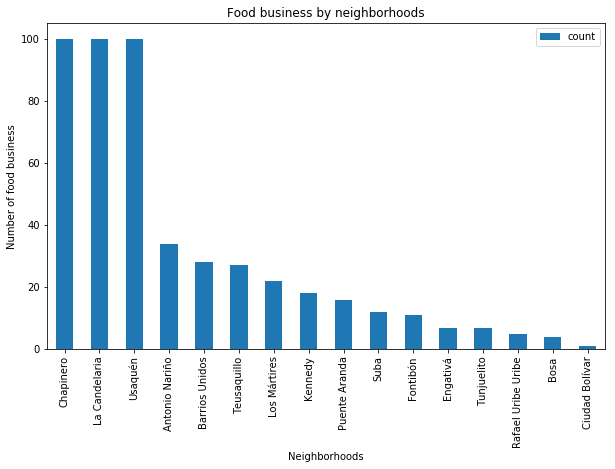

In [18]:
df_neighborhood_tmp.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Neighborhoods')
plt.ylabel('Number of food business')
plt.title('Food business by neighborhoods')
plt.show()

In [19]:
categories_list = full_venues_df['categories'].unique()
categories_list

array(['Park', 'Spanish Restaurant', 'Peruvian Restaurant', 'Pub',
       'Restaurant', 'Brewery', 'Asian Restaurant', 'Pizza Place',
       'Italian Restaurant', 'Seafood Restaurant', 'Flea Market',
       'Mediterranean Restaurant', 'Coffee Shop', 'French Restaurant',
       'Steakhouse', 'Japanese Restaurant', 'Creperie', 'Café',
       'Gastropub', 'Hotel', 'Dessert Shop', 'South American Restaurant',
       'Juice Bar', 'Deli / Bodega', 'Burger Joint',
       'Indie Movie Theater', 'Miscellaneous Shop',
       'Middle Eastern Restaurant', 'BBQ Joint', 'Food Court',
       'Bike Rental / Bike Share', 'Diner', 'Gymnastics Gym',
       'Comfort Food Restaurant', 'Bar', 'Shopping Mall', 'Lounge',
       'Tea Room', 'Nightclub', 'Greek Restaurant', 'Dog Run',
       'Mexican Restaurant', 'Latin American Restaurant',
       'American Restaurant', 'Indian Restaurant', 'Bed & Breakfast',
       'Ice Cream Shop', 'Whisky Bar', 'Brazilian Restaurant',
       'Gourmet Shop', 'Bakery', 'Break

In [20]:
cat_count = full_venues_df[['Neighborhood','categories']].groupby('categories').count()
cat_count = cat_count.rename(columns={'Neighborhood': 'Category Count'}).sort_values(by='Category Count', ascending=False)

cat_count = cat_count[0:11]
cat_count

,Category Count
categories,
Restaurant,36
Café,18
Latin American Restaurant,18
Burger Joint,17
Italian Restaurant,16
Coffee Shop,16
Park,14
Pizza Place,14
Hotel,12


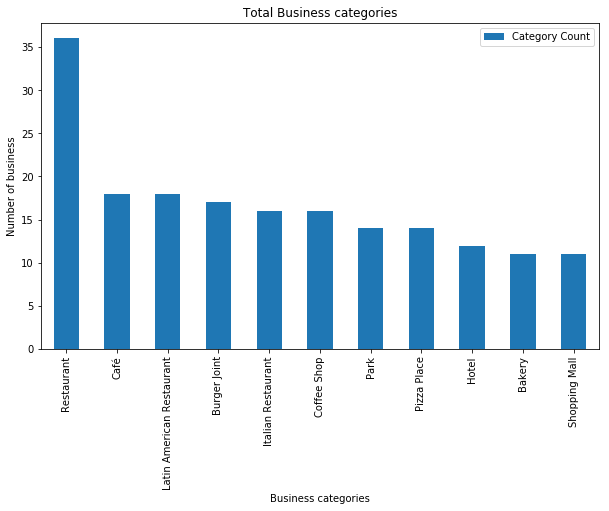

In [21]:
cat_count.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Business categories')
plt.ylabel('Number of business')
plt.title('Total Business categories')

plt.show()

In [22]:
coffee_shops = full_venues_df[full_venues_df['categories'] == 'Coffee Shop'].reset_index(drop=True)
coffee_shops = coffee_shops.append(full_venues_df[full_venues_df['categories'] == 'Café'].reset_index(drop=True), ignore_index=True)
coffee_shops

,name,lat,lng,categories,Neighborhood
0,Starbucks,4.695327,-74.031175,Coffee Shop,Usaquén
1,Juan Valdéz Café,4.692852,-74.032456,Coffee Shop,Usaquén
2,Café Quindío,4.693978,-74.032968,Coffee Shop,Usaquén
3,Catación Pública,4.695898,-74.028142,Coffee Shop,Usaquén
4,Starbucks,4.692408,-74.034384,Coffee Shop,Usaquén
5,Oma,4.647909,-74.063799,Coffee Shop,Chapinero
6,Starbucks,4.651285,-74.059096,Coffee Shop,Chapinero
7,Tostao',4.643544,-74.062821,Coffee Shop,Chapinero
8,Efresal,4.626503,-74.146903,Coffee Shop,Kennedy
9,Juan Valdez Café,4.643856,-74.091203,Coffee Shop,Teusaquillo


In [23]:
bogota_map = folium.Map(location=[latitude, longitude], tiles="OpenStreetMap", zoom_start=11)

for lat, lng, borough, neighborhood in zip(coffee_shops['lat'], coffee_shops['lng'], coffee_shops['name'], coffee_shops['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#373F51',
        fill=True,
        fill_color='#373F51',
        fill_opacity=0.3,
        parse_html=False).add_to(bogota_map)  
bogota_map

In [24]:
total_coffee_shops = len(coffee_shops.index)
total_coffee_shops

34

In [25]:
venues_neighborhood_2 = coffee_shops.groupby(['Neighborhood'])['categories'].apply(', '.join).reset_index()
count = coffee_shops.groupby(['Neighborhood']).count()
count.reset_index(inplace=True)
venues_neighborhood_2['count']=count['name']
venues_neighborhood_2['percent']=venues_neighborhood_2['count']/total_coffee_shops
venues_neighborhood_2.sort_values(by='count', ascending=False, inplace=True)
venues_neighborhood_2

,Neighborhood,categories,count,percent
2,La Candelaria,"Coffee Shop, Coffee Shop, Coffee Shop, Coffee ...",15,0.441176
0,Chapinero,"Coffee Shop, Coffee Shop, Coffee Shop, Café, C...",8,0.235294
5,Usaquén,"Coffee Shop, Coffee Shop, Coffee Shop, Coffee ...",8,0.235294
1,Kennedy,Coffee Shop,1,0.029412
3,Los Mártires,Coffee Shop,1,0.029412
4,Teusaquillo,Coffee Shop,1,0.029412
